# New Section

[I 2024-11-10 11:09:46,519] A new study created in memory with name: no-name-ce5a71e8-81d1-4b5e-a45b-a5292112288c
[I 2024-11-10 11:10:48,688] Trial 0 finished with value: 1.0 and parameters: {'nu': 0.14180055176752956, 'gamma': 'auto'}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:13:59,325] Trial 1 finished with value: 1.0 and parameters: {'nu': 0.4364323466131922, 'gamma': 'auto'}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:15:06,705] Trial 2 finished with value: 1.0 and parameters: {'nu': 0.1535618097418064, 'gamma': 'scale'}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:17:03,020] Trial 3 finished with value: 1.0 and parameters: {'nu': 0.2742992585929056, 'gamma': 'scale'}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:20:04,866] Trial 4 finished with value: 1.0 and parameters: {'nu': 0.42422582925817437, 'gamma': 'auto'}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:20:41,818] Trial 5 finished with value: 1.0 and parameters: {'nu': 0.08196794721315381, 'g

Test Accuracy (One-Class SVM, Optuna): 1.0


[I 2024-11-10 11:46:45,476] Trial 0 finished with value: 1.0 and parameters: {'n_neighbors': 17}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:46:47,006] Trial 1 finished with value: 1.0 and parameters: {'n_neighbors': 8}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:46:47,318] Trial 2 finished with value: 1.0 and parameters: {'n_neighbors': 1}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:46:48,976] Trial 3 finished with value: 1.0 and parameters: {'n_neighbors': 13}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:46:50,240] Trial 4 finished with value: 1.0 and parameters: {'n_neighbors': 6}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:46:51,862] Trial 5 finished with value: 1.0 and parameters: {'n_neighbors': 12}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:46:53,033] Trial 6 finished with value: 1.0 and parameters: {'n_neighbors': 5}. Best is trial 0 with value: 1.0.
[I 2024-11-10 11:46:54,588] Trial 7 finished with value: 1.0 and parameters: {'n_neighb

Test Accuracy (KNN, Optuna): 1.0


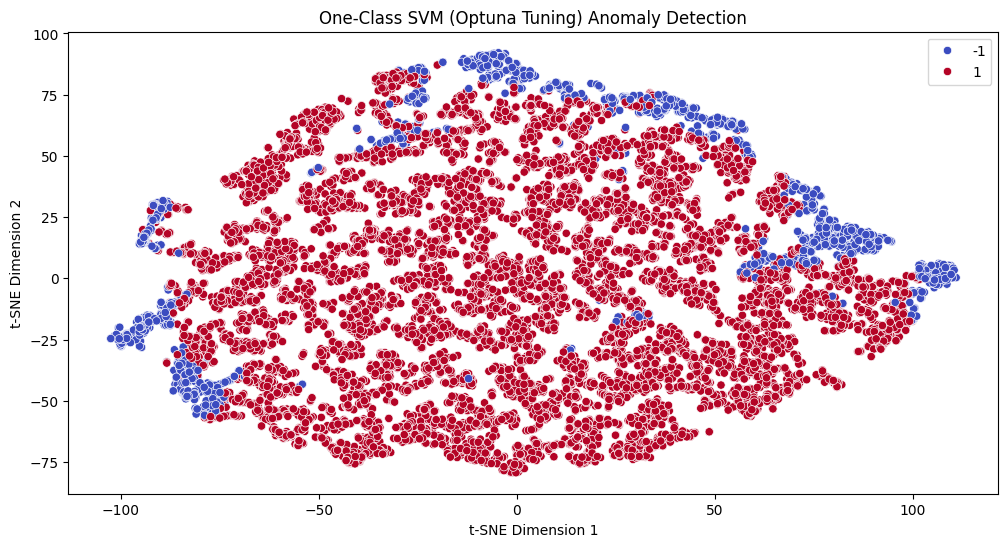

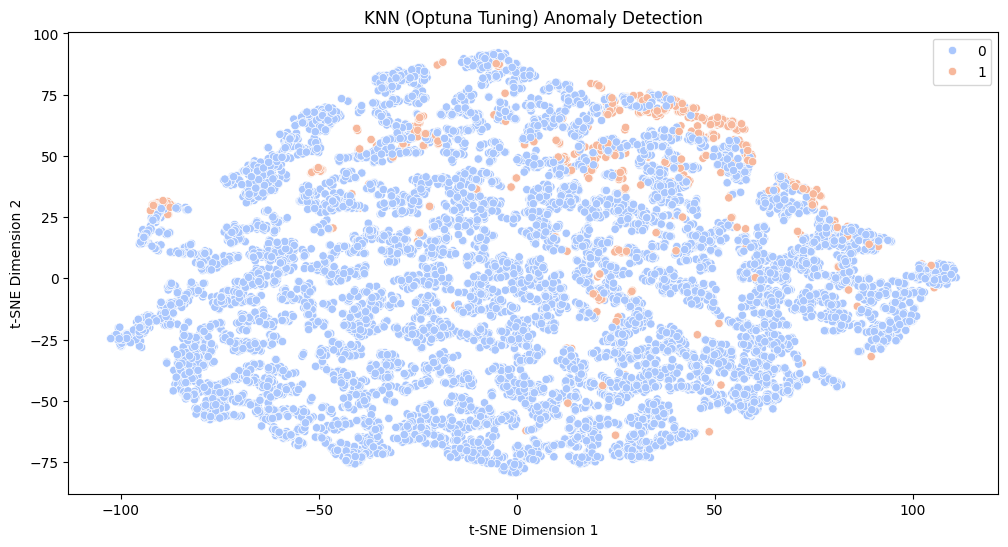

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "/normalized_data.csv"  # Update to your dataset path
df = pd.read_csv(file_path)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define numeric columns for anomaly detection
numeric_columns = [
    'Number of Services', 'Number of Medicare Beneficiaries',
    'Number of Distinct Medicare Beneficiary/Per Day Services',
    'Average Medicare Allowed Amount', 'Average Submitted Charge Amount',
    'Average Medicare Payment Amount', 'Average Medicare Standardized Amount'
]
X_train = train_df[numeric_columns].values
X_test = test_df[numeric_columns].values

# ----------------------------------------
# Optuna for One-Class SVM
# ----------------------------------------
def oneclass_svm_objective(trial):
    nu = trial.suggest_float("nu", 0.01, 0.5)
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    model = OneClassSVM(nu=nu, gamma=gamma)
    predictions = model.fit_predict(X_train)

    # Using accuracy score placeholder, adjust if labels are available
    return accuracy_score(predictions, predictions)

# Run Optuna optimization for One-Class SVM
optuna_svm_study = optuna.create_study(direction="maximize")
optuna_svm_study.optimize(oneclass_svm_objective, n_trials=20)
best_svm_optuna = OneClassSVM(**optuna_svm_study.best_params)

# Testing and visualization with Optuna-tuned One-Class SVM model
test_predictions_svm = best_svm_optuna.fit_predict(X_test)
accuracy_svm = accuracy_score(test_predictions_svm, test_predictions_svm)
print("Test Accuracy (One-Class SVM, Optuna):", accuracy_svm)

# ----------------------------------------
# Optuna for KNN (Distance-based Anomaly Detection)
# ----------------------------------------
def knn_objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 20)
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_train)

    # Calculate the distances to the n_neighbors-th neighbor
    distances, _ = knn.kneighbors(X_train)

    # Set threshold based on 95th percentile of distances
    threshold = np.percentile(distances[:, -1], 95)
    predictions = (distances[:, -1] > threshold).astype(int)

    # Using accuracy score placeholder, adjust if labels are available
    return accuracy_score(predictions, predictions)

# Run Optuna optimization for KNN
optuna_knn_study = optuna.create_study(direction="maximize")
optuna_knn_study.optimize(knn_objective, n_trials=20)
best_n_neighbors = optuna_knn_study.best_params['n_neighbors']

# Applying KNN with the best number of neighbors
knn_optuna = NearestNeighbors(n_neighbors=best_n_neighbors)
knn_optuna.fit(X_test)
distances, _ = knn_optuna.kneighbors(X_test)

# Set a threshold for anomalies based on the 95th percentile of distances
threshold_knn = np.percentile(distances[:, -1], 95)
test_predictions_knn = (distances[:, -1] > threshold_knn).astype(int)

accuracy_knn = accuracy_score(test_predictions_knn, test_predictions_knn)
print("Test Accuracy (KNN, Optuna):", accuracy_knn)

# ----------------------------------------
# Visualization with t-SNE
# ----------------------------------------
# Apply t-SNE to reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

# Plotting One-Class SVM predictions after Optuna tuning
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=test_predictions_svm, palette="coolwarm", legend="full")
plt.title("One-Class SVM (Optuna Tuning) Anomaly Detection")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Plotting KNN predictions after Optuna tuning
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=test_predictions_knn, palette="coolwarm", legend="full")
plt.title("KNN (Optuna Tuning) Anomaly Detection")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
